In [1]:
import Preprocessing as pp
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
temp_data_folder = "../Data/Temp_Data/"
image_path = "../Images/"
image_subfolder = "Proposal/"
image_folder = image_path + image_subfolder

pp.checkFolder(temp_data_folder)
pp.checkFolder(image_path)
pp.checkFolder(image_folder)

Folder already exists.
Folder already exists.
Folder already exists.


In [3]:
#colors
kit_green = '#009682'
kit_blue = '#4664AA'
kit_orange = '#DF9B1B'

In [4]:
df_1 = pp.openCSVFile('experiment_1_short.csv', temp_data_folder)
df_4b = pp.openCSVFile('experiment_4b_short.csv', temp_data_folder)
df_9 = pp.openCSVFile('experiment_9_short.csv', temp_data_folder)

In [5]:
data = df_4b.set_index('time').diff(10)

In [6]:
diff_1 = df_1.set_index('time').diff(10)

In [7]:
el_maxi = df_4b.loc[df_4b.idxmax()['el_power']]['el_power']
el_mini = df_4b.loc[df_4b.idxmin()['el_power']]['el_power']

## Dynamic Shift and supervised learning 

In [45]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [46]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [47]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [48]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [44]:
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

## Enough of the chit chat 

In [184]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)

In [185]:
def fit_lstm(X_train, y_train, X_test, y_test, nb_epoch, neurons):
    np.random.seed(5)
    start = time.time()
    X, y = X_train, y_train
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, activation = 'relu', input_shape = (64, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=300, verbose=1, shuffle=False, validation_data=(X_t, y_test), callbacks = [es])
        model.reset_states()
    end = time.time()
    duration = end - start
    return model, duration

In [186]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [187]:
y_train = df_4b['el_power']
y_train_dif = data['el_power']
X_train = df_4b['input_voltage']
train = [X_train, y_train]

y_test = df_1['el_power']
y_test_dif = diff_1['el_power']
X_test = df_1['input_voltage']
test = [X_test, y_test]

In [188]:
X_train = np.array(X_train[:,])
X_test = np.array(X_test[:,])
y_train = np.array(y_train[:,])
y_test = np.array(y_test[:,])

In [189]:
scaler, X_train, X_test = scale(X_train.reshape(-1,1), X_test.reshape(-1,1))
scaler_y, y_train, y_test = scale(y_train.reshape(-1,1), y_test.reshape(-1,1))

In [190]:
lstm_model, duration = fit_lstm(X_train, y_train, X_test, y_test, 10, 64)

Epoch 1/300
330/330 [==============================] - 1s 2ms/step - loss: 0.3875 - val_loss: 0.2470
Epoch 2/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1963 - val_loss: 0.2099
Epoch 3/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1934 - val_loss: 0.2088
Epoch 4/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1924 - val_loss: 0.2083
Epoch 5/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1918 - val_loss: 0.2080
Epoch 6/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1915 - val_loss: 0.2078
Epoch 7/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1912 - val_loss: 0.2076
Epoch 8/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1910 - val_loss: 0.2075
Epoch 9/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1909 - val_loss: 0.2074
Epoch 10/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1907 - val_lo

330/330 [==============================] - 0s 1ms/step - loss: 0.1875 - val_loss: 0.2000
Epoch 75/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1875 - val_loss: 0.1999
Epoch 76/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1874 - val_loss: 0.1998
Epoch 77/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1874 - val_loss: 0.1997
Epoch 78/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.1996
Epoch 79/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.1995
Epoch 80/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.1994
Epoch 81/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1872 - val_loss: 0.1993
Epoch 82/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1872 - val_loss: 0.1992
Epoch 83/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1872 - val_loss: 

Epoch 154/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.1925
Epoch 155/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.1924
Epoch 156/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1849 - val_loss: 0.1923
Epoch 157/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1849 - val_loss: 0.1923
Epoch 158/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1849 - val_loss: 0.1922
Epoch 159/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.1921
Epoch 160/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.1921
Epoch 161/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.1920
Epoch 162/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.1919
Epoch 163/300
330/330 [==============================] - 0s 1ms/step - lo

330/330 [==============================] - 0s 1ms/step - loss: 0.1834 - val_loss: 0.1883
Epoch 234/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1834 - val_loss: 0.1883
Epoch 235/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1834 - val_loss: 0.1882
Epoch 236/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1834 - val_loss: 0.1882
Epoch 237/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1833 - val_loss: 0.1882
Epoch 238/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1833 - val_loss: 0.1881
Epoch 239/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1833 - val_loss: 0.1881
Epoch 240/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1833 - val_loss: 0.1880
Epoch 241/300
330/330 [==============================] - ETA: 0s - loss: 0.159 - 0s 1ms/step - loss: 0.1833 - val_loss: 0.1880
Epoch 242/300
330/330 [==============================] - 0s 1ms

330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1850
Epoch 13/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1849
Epoch 14/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1849
Epoch 15/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1849
Epoch 16/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1848
Epoch 17/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.1848
Epoch 18/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.1848
Epoch 19/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.1847
Epoch 20/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.1847
Epoch 21/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 

330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1825
Epoch 93/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1825
Epoch 94/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1825
Epoch 95/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1825
Epoch 96/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1824
Epoch 97/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1824
Epoch 98/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1824
Epoch 99/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1824
Epoch 100/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.1823
Epoch 101/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss

330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1809
Epoch 172/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1809
Epoch 173/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1808
Epoch 174/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1808
Epoch 175/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1808
Epoch 176/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1808
Epoch 177/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.1807
Epoch 178/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1800 - val_loss: 0.1807
Epoch 179/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1800 - val_loss: 0.1807
Epoch 180/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1800 - v

330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1792
Epoch 251/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1792
Epoch 252/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1792
Epoch 253/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 254/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 255/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 256/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 257/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1790
Epoch 258/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1790
Epoch 259/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1793 - v

Epoch 30/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.1777
Epoch 31/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.1777
Epoch 32/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1777
Epoch 33/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1777
Epoch 34/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1776
Epoch 35/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1776
Epoch 36/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1776
Epoch 37/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1776
Epoch 38/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1776
Epoch 39/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1786

Epoch 110/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 111/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 112/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 113/300
330/330 [==============================] - 0s 2ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 114/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 115/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1765
Epoch 116/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1764
Epoch 117/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1764
Epoch 118/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1764
Epoch 119/300
330/330 [==============================] - 0s 1ms/step - lo

330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1753
Epoch 190/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1753
Epoch 191/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1753
Epoch 192/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1753
Epoch 193/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1752
Epoch 194/300
330/330 [==============================] - 1s 2ms/step - loss: 0.1776 - val_loss: 0.1752
Epoch 195/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1752
Epoch 196/300
330/330 [==============================] - 1s 2ms/step - loss: 0.1776 - val_loss: 0.1752
Epoch 197/300
330/330 [==============================] - 1s 2ms/step - loss: 0.1776 - val_loss: 0.1752
Epoch 198/300
330/330 [==============================] - 1s 2ms/step - loss: 0.1776 - v

330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 269/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 270/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 271/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 272/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 273/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1741
Epoch 274/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1740
Epoch 275/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1740
Epoch 276/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.1740
Epoch 277/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1772 - v

330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 49/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 50/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 51/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 52/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 53/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 54/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 55/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 56/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 57/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 

330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 2/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 3/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 4/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 5/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 6/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.1735
Epoch 7/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.1735
Epoch 8/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.1735
Epoch 9/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.1735
Epoch 10/300
330/330 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.1735
E

In [191]:
print('Das Training des LSTM auf den downgesampledten Daten hat %5.3f Sekunden gedauert.' %duration)

Das Training des LSTM auf den downgesampledten Daten hat 490.096 Sekunden gedauert.


In [192]:
X_train_reshaped = X_train[:, 0].reshape(len(X_train), 1, 1)
train_pred = lstm_model.predict(X_train_reshaped, batch_size=1)

In [193]:
X_test_reshaped = X_test[:, 0].reshape(len(X_test), 1, 1)
pred = lstm_model.predict(X_test_reshaped, batch_size=1)

In [194]:
sc = MinMaxScaler(feature_range= (el_mini, el_maxi))
sc.fit(y_test)

MinMaxScaler(feature_range=(1132.0, 3386.0))

In [195]:
df_1['el_predictions'] = sc.transform(pred)
y_test_true = sc.transform(y_test)

In [196]:
df_4b['el_predictions'] = sc.transform(train_pred)
y_train_true = sc.transform(y_train)

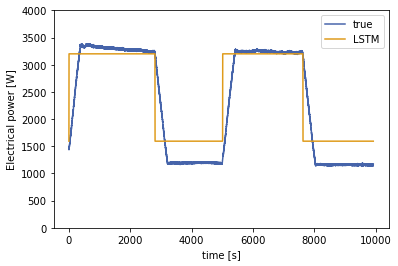

In [197]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

pyplot.plot(y_test_true, label = 'true', color = kit_blue)
pyplot.plot(df_1['el_predictions'], label = 'LSTM', color = kit_orange)

pyplot.legend()
pyplot.ylabel('Electrical power [W]')
pyplot.ylim([0, 4000])
pyplot.xlabel('time [s]')

pyplot.savefig(image_folder + timestr + '_ex1_LSTM_electric.svg')
pyplot.savefig(image_folder + timestr + '_ex1_LSTM_electric.png')
pyplot.show()

In [198]:
pp.measureDifference(df_1, 'el_power', 'el_predictions')

The RMSE is 546.623
The R2-score is 0.707
The MAE is 393.410
The MaxAE is 2141.559


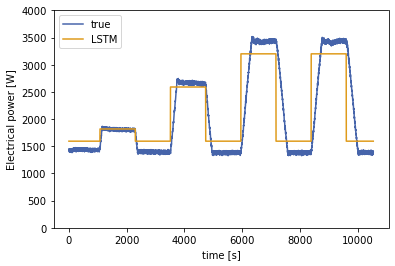

In [199]:
pyplot.plot(y_train_true, label = 'true', color = kit_blue)
pyplot.plot(df_4b['el_predictions'], label = 'LSTM', color = kit_orange)

pyplot.legend()
pyplot.ylabel('Electrical power [W]')
pyplot.ylim([0, 4000])
pyplot.xlabel('time [s]')

pyplot.savefig(image_folder + timestr + '_ex4_LSTM_electric.svg')
pyplot.savefig(image_folder + timestr + '_ex4_LSTM_electric.png')
pyplot.show()